Downloading and unarchiveing the amazon data, it is already split to train and test, we are going to use it for training and validation, we will be testing with our own data.

In [3]:
!wget "https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz"
!tar -xvf amazon_review_polarity_csv.tgz

--2020-12-05 19:37:54--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.28.214
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.28.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘amazon_review_polarity_csv.tgz.1’

amazon_review_polar 100%[===================>] 656.45M  27.1MB/s    in 41s     

2020-12-05 19:38:36 (15.9 MB/s) - ‘amazon_review_polarity_csv.tgz.1’ saved [688339454/688339454]

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


Prepearing the data: the firs column of the dataset is the lable: labble 2 is positive and lable 1 is negative
the second row is the subject, and the third is the full rewiev

In [1]:
import torch
import torch.nn as nn
import torch.optim

from sklearn.model_selection import train_test_split

import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from tqdm import tqdm

from transformers import BertTokenizer, BertForSequenceClassification

#by loading the data with the right column names we dont have to do much in terms of prepearing
train_data_youtube = pd.read_csv("youtube_review_csv/data_labeled_train.csv", names=("ind", "data", "labels"))
test_data = pd.read_csv("youtube_review_csv/data_labeled_test.csv", names=("ind", "data", "labels"))

#by loading the data with the right column names we dont have to do much in terms of prepearing
train_data_amazon = pd.read_csv("amazon_review_polarity_csv/train.csv", names=("labels", "subject", "data"))
valid_data_amazon = pd.read_csv("amazon_review_polarity_csv/test.csv", names=("labels", "subject", "data"))

display(train_data_youtube)

,ind,data,labels
0,0,Save 10 and Free Worldwide Shipping at Ridge W...,0
1,1,Great review especially the part where you sai...,1
2,2,imo astro s playroom deserves more credit it w...,0
3,3,Forget trimming your nose hair WAX it when you...,0
4,4,Sounds like we need Linus to review Bugsnax,0
...,...,...,...
189,192,El final me animo mas a sobrevivir al 2020,0
190,193,When Will PS5 shipping to Malaysia,2
191,196,Everyone Here for Security breachCod FFXVI Spi...,0
192,198,Me i am not getting the ps5 until the price dr...,1


In [2]:
if not torch.cuda.is_available():
    print("WARNING. GPU is not available. Did you change your runtime to GPU?")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = 3)

_ = model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [3]:
for p in model.base_model.parameters():
    p.requires_grad = False

In [4]:
# training loop

batch_size = 512
num_epochs = 5
patience = 1
optimizer = torch.optim.Adam(model.parameters())

def training():

    metrics = defaultdict(list)

    stag = 0
    prev_loss = float('inf')
    prev_accuraccy = 0.0

    for epoch in range(num_epochs):
        start_positions = list(range(0, len(train_data), batch_size))
        np.random.shuffle(start_positions)

        train_acc = 0
        train_loss = 0
        train_len = 0
        model.train()

        #we will use the tqdm progress bare librarry to better monitor the training
        start_positions = tqdm(start_positions)
        start_positions.set_description(f'Epoch {epoch + 1}/{num_epochs} training ')

        for start in start_positions:
            batch = train_data.iloc[start:start+batch_size]
            optimizer.zero_grad()
            encoded = tokenizer(batch.data.values.tolist(), truncation=True, max_length=128, padding=True, return_tensors='pt')
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)
            labels = torch.LongTensor(batch["labels"].tolist()).to(device)

            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

            loss = outputs[0]
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            predictions = outputs[1].argmax(axis=1)
            train_acc += torch.eq(predictions, labels).sum().item()

            train_len += batch_size #we count how many data we trained on to calculate the accuraccy on the fly
            if(train_len > len(train_data)): #the last batch might be smaller so we need to correct for that to get an accurate accuraccy
                train_len = len(train_data)
            start_positions.set_postfix({"loss" : train_loss, "accuraccy" : (train_acc/train_len)}) #we update loss and accuraccy after each batch

        #print(f"valid_loss {train_loss} acc {train_acc / len(train_data)}")
        metrics['train_everidge_loss'].append(train_loss / len(train_data))
        metrics['train_accuracy'].append(train_acc / len(train_data))

        start_positions = list(range(0, len(valid_data), batch_size))
        valid_acc = 0
        valid_loss = 0
        valid_len = 0
        model.eval()

        #we will use the tqdm progress bare librarry to better monitor the validation
        start_positions = tqdm(start_positions)
        start_positions.set_description(f'Epoch {epoch + 1}/{num_epochs} validating ')

        for start in start_positions:
            batch = valid_data.iloc[start:start+batch_size]
            encoded = tokenizer(batch.data.values.tolist(), truncation=True, max_length=128, padding=True, return_tensors='pt')
            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)
            labels = torch.LongTensor(batch["labels"].tolist()).to(device)

            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

            loss = outputs[0]
            valid_loss += loss.item()

            predictions = outputs[1].argmax(axis=1)
            valid_acc += torch.eq(predictions, labels).sum().item()

            valid_len += batch_size #we count how many data we validated on to calculate the accuraccy on the fly
            if(valid_len > len(valid_data)): #the last batch might be smaller so we need to correct for that to get an accurate accuraccy
                valid_len = len(valid_data)
            start_positions.set_postfix({"loss" : valid_loss, "accuraccy" : (valid_acc/valid_len)}) #we update loss and accuraccy after each batch
        
        #print(f"valid_loss {valid_loss} acc {valid_acc / len(valid_data)}")

        metrics['valid_everidge_loss'].append(train_loss / len(valid_data))
        metrics['valid_accuracy'].append(valid_acc / len(valid_data))

        #check for early stopping after each epoch
        if (valid_loss >= prev_loss and valid_acc <= prev_accuraccy):
            stag += 1
        else:
            stag = 0
        if stag > patience:
            break

        prev_loss, prev_accuraccy = valid_loss, valid_acc

    return metrics

In [5]:
# evaluation
def evaluation():
    start_positions = list(range(0, len(test_data), batch_size))
    test_acc = 0
    test_loss = 0
    test_len = 0
    model.eval()
    
    #we will use the tqdm progress bare librarry to better monitor the testing
    start_positions = tqdm(start_positions)
    start_positions.set_description(f'Testing ')

    for start in start_positions:
        batch = test_data.iloc[start:start+batch_size]
        encoded = tokenizer(batch.data.values.tolist(), truncation=True, max_length=128, padding=True, return_tensors='pt')
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)
        labels = torch.LongTensor(batch["labels"].tolist()).to(device)

        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

        loss = outputs[0]
        test_loss += loss.item()

        predictions = outputs[1].argmax(axis=1)
        test_acc += torch.eq(predictions, labels).sum().item()

        test_len += batch_size #we count how many data we validated on to calculate the accuraccy on the fly
        if(test_len > len(test_data)): #the last batch might be smaller so we need to correct for that to get an accurate accuraccy
            test_len = len(test_data)
        start_positions.set_postfix({"loss" : test_loss, "accuraccy" : (test_acc/test_len)}) #we update loss and accuraccy after each batch

    #print(f"test_loss {test_loss} acc {test_acc / len(test_data)}")
    return [test_loss / len(test_data), test_acc / len(test_data)]

We will try what happens when training our own dara first

In [6]:
#split our data to training and validation
train_data = train_data_youtube.head(len(train_data_youtube)-50)
valid_data = train_data_youtube.tail(50)

num_epochs = 100

first_metrics = training()
first_testmetrics = evaluation()

Testing : 100%|██████████| 1/1 [00:00<00:00,  7.55it/s, loss=1.23, accuraccy=0.36]


test everidge loss:0.024673030376434327, test accuraccy:0.36


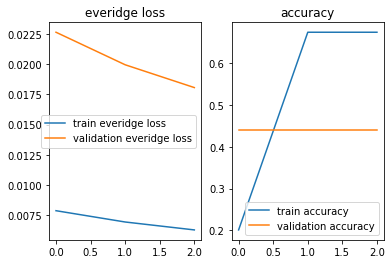

In [7]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(data=first_metrics['train_everidge_loss'], ax=ax[0], label='train everidge loss')
sns.lineplot(data=first_metrics['valid_everidge_loss'], ax=ax[0], label='validation everidge loss')

ax[0].set_title('everidge loss')
ax[1].set_title('accuracy')

sns.lineplot(data=first_metrics['train_accuracy'], ax=ax[1], label='train accuracy')
sns.lineplot(data=first_metrics['valid_accuracy'], ax=ax[1], label='validation accuracy')
print(f'test everidge loss:{first_testmetrics[0]}, test accuraccy:{first_testmetrics[1]}')

We will train on a portion of the amazon data next

In [8]:
#we will only use a portion of the datasets due to time concerns
train_data = train_data_amazon.head(10000)
valid_data = train_data_amazon.tail(1000)

num_epochs = 20

second_metrics = training()
second_testmetrics = evaluation()

Testing : 100%|██████████| 1/1 [00:00<00:00,  6.77it/s, loss=2.97, accuraccy=0.42]


test everidge loss:0.05945210456848145, test accuraccy:0.42


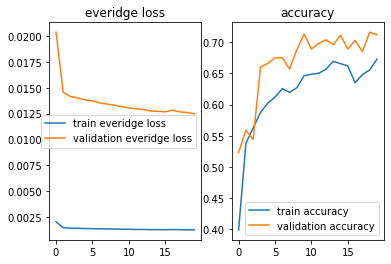

In [9]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(data=second_metrics['train_everidge_loss'], ax=ax[0], label='train everidge loss')
sns.lineplot(data=second_metrics['valid_everidge_loss'], ax=ax[0], label='validation everidge loss')

ax[0].set_title('everidge loss')
ax[1].set_title('accuracy')

sns.lineplot(data=second_metrics['train_accuracy'], ax=ax[1], label='train accuracy')
sns.lineplot(data=second_metrics['valid_accuracy'], ax=ax[1], label='validation accuracy')
print(f'test everidge loss:{second_testmetrics[0]}, test accuraccy:{second_testmetrics[1]}')

And finally train on our data again

In [11]:
#split our data to training and validation
train_data = train_data_youtube.head(len(train_data_youtube)-50)
valid_data = train_data_youtube.tail(50)

num_epochs = 100
optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10 #we well be using a smaller learning rate for this final step

third_metrics = training()
third_testmetrics = evaluation()

Testing : 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, loss=1.11, accuraccy=0.42]


test everidge loss:0.022213976383209228, test accuraccy:0.42


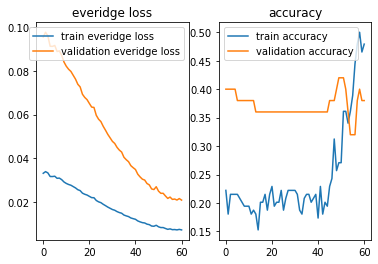

In [12]:
fig, ax = plt.subplots(1, 2)

sns.lineplot(data=third_metrics['train_everidge_loss'], ax=ax[0], label='train everidge loss')
sns.lineplot(data=third_metrics['valid_everidge_loss'], ax=ax[0], label='validation everidge loss')

ax[0].set_title('everidge loss')
ax[1].set_title('accuracy')

sns.lineplot(data=third_metrics['train_accuracy'], ax=ax[1], label='train accuracy')
sns.lineplot(data=third_metrics['valid_accuracy'], ax=ax[1], label='validation accuracy')
print(f'test everidge loss:{third_testmetrics[0]}, test accuraccy:{third_testmetrics[1]}')

And finnally summaryzing our results

<AxesSubplot:title={'center':'accuracy'}>

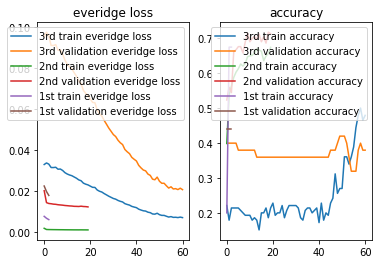

In [13]:
fig, ax = plt.subplots(1, 2)

ax[0].set_title('everidge loss')
ax[1].set_title('accuracy')

sns.lineplot(data=third_metrics['train_everidge_loss'], ax=ax[0], label='3rd train everidge loss')
sns.lineplot(data=third_metrics['valid_everidge_loss'], ax=ax[0], label='3rd validation everidge loss')

sns.lineplot(data=third_metrics['train_accuracy'], ax=ax[1], label='3rd train accuracy')
sns.lineplot(data=third_metrics['valid_accuracy'], ax=ax[1], label='3rd validation accuracy')

sns.lineplot(data=second_metrics['train_everidge_loss'], ax=ax[0], label='2nd train everidge loss')
sns.lineplot(data=second_metrics['valid_everidge_loss'], ax=ax[0], label='2nd validation everidge loss')

sns.lineplot(data=second_metrics['train_accuracy'], ax=ax[1], label='2nd train accuracy')
sns.lineplot(data=second_metrics['valid_accuracy'], ax=ax[1], label='2nd validation accuracy')

sns.lineplot(data=first_metrics['train_everidge_loss'], ax=ax[0], label='1st train everidge loss')
sns.lineplot(data=first_metrics['valid_everidge_loss'], ax=ax[0], label='1st validation everidge loss')

sns.lineplot(data=first_metrics['train_accuracy'], ax=ax[1], label='1st train accuracy')
sns.lineplot(data=first_metrics['valid_accuracy'], ax=ax[1], label='1st validation accuracy')

<AxesSubplot:title={'center':'test accuracy'}>

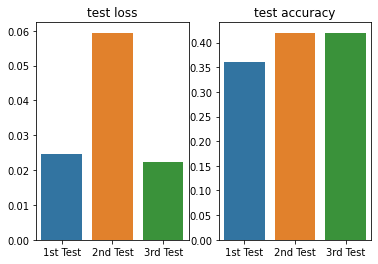

In [14]:
fig, ax = plt.subplots(1, 2)

loss_data = pd.DataFrame([[first_testmetrics[0], second_testmetrics[0], third_testmetrics[0]]], columns=["1st Test", "2nd Test", "3rd Test"])
acc_data = pd.DataFrame([[first_testmetrics[1], second_testmetrics[1], third_testmetrics[1]]], columns=["1st Test", "2nd Test", "3rd Test"])

ax[0].set_title('test loss')
ax[1].set_title('test accuracy')

sns.barplot(data=loss_data, ax=ax[0], label="loss")
sns.barplot(data=acc_data, ax=ax[1], label='accuracy')
